<a href="https://colab.research.google.com/github/MariiaS/olid/blob/main/Offensive_speech_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()


     |████████████████████████████████| 727kB 2.1MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
     |████████████████████████████████| 1.1MB 37.7MB/s 
     |████████████████████████████████| 194kB 25.7MB/s 
     |████████████████████████████████| 51kB 5.9MB/s 
     |████████████████████████████████| 40kB 5.5MB/s 
     |████████████████████████████████| 92kB 10.4MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
     |████████████████████████████████| 51kB 6.6MB/s 
     |████████████████████████████████| 2.6MB 40.8MB/s 
Mounted at /content/gdrive


The **Offensive Language Identification Dataset (OLID)** contains a collection of 14,200 annotated English tweets using an annotation model that encompasses following three levels:
 
* A: Offensive Language Detection
* B: Categorization of Offensive Language
* C: Offensive Language Target Identification
 
OLID was the official dataset used in the OffensEval: Identifying and Categorizing Offensive Language in Social Media (SemEval 2019 - Task 6) shared task. 

OLID has been in students projects in different universities. To the best of our knowledge, so far it has been used by students at The University of Arizona (USA), Imperial College London (UK), and University of Leeds (UK) Some of the student system papers are available here.

If you used OLID, please refer to this paper:


> Predicting the Type and Target of Offensive Posts in Social Media; Zampieri, Marcos and Malmasi, Shervin and Nakov, Preslav and Rosenthal, Sara and Farra, Noura and Kumar, Ritesh; Proceedings of NAACL; 2019



 

During my experiments with Natural language processing I am going to use **fastai**, which is a framework built on top of PyTorch. **fastai** is a deep learning library which provides practitioners with high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains, and provides researchers with low-level components that can be mixed and matched to build new approaches. It aims to do both things without substantial compromises in ease of use, flexibility, or performance. This is possible thanks to a carefully layered architecture, which expresses common underlying patterns of many deep learning and data processing techniques in terms of decoupled abstractions. These abstractions can be expressed concisely and clearly by leveraging the dynamism of the underlying Python language and the flexibility of the PyTorch library. fastai includes:

* A new type dispatch system for Python along with a semantic type hierarchy for tensors
* A GPU-optimized computer vision library which can be extended in pure Python
* An optimizer which refactors out the common functionality of modern optimizers into two basic pieces, allowing optimization algorithms to be implemented in 4–5 lines of code
* A novel 2-way callback system that can access any part of the data, model, or optimizer and change it at any point during training
* A new data block API

**fastai** is organized around two main design goals: to be approachable and rapidly productive, while also being deeply hackable and configurable. It is built on top of a hierarchy of lower-level APIs which provide composable building blocks. This way, a user wanting to rewrite part of the high-level API or add particular behavior to suit their needs does not have to learn how to use the lowest level.
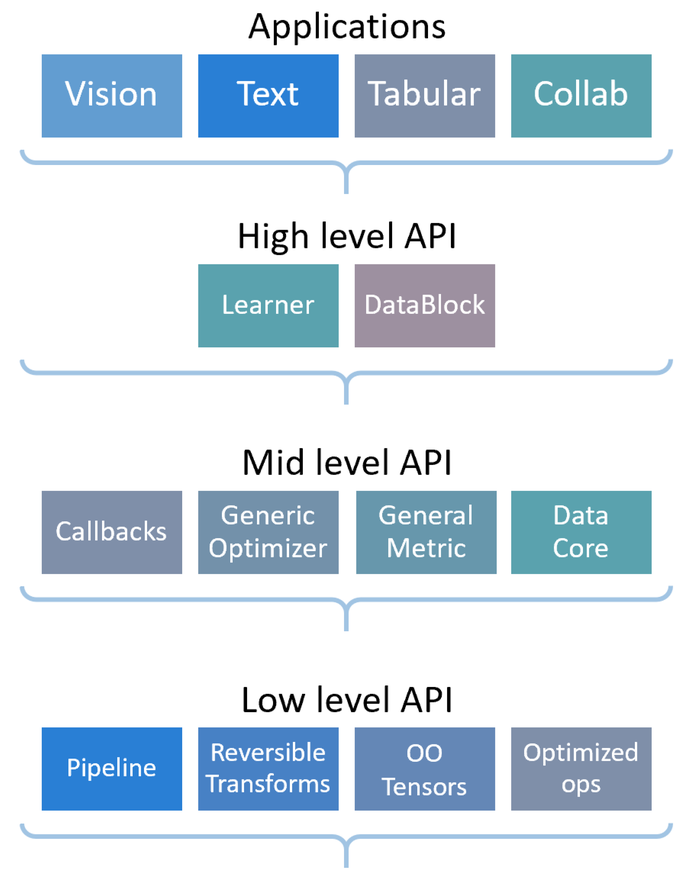

In [ ]:
from fastbook import *
from fastai.text.all import *
import pandas as pd

---
Let's take a look at the data



In [ ]:
pathToFolder = Path("/content/gdrive/MyDrive/Study/NLP/OLIDv1.0/")
data = pd.read_csv("/content/gdrive/MyDrive/Study/NLP/OLIDv1.0/olid-training-v1.0.tsv", sep='\t', header=0)
data_top = data.head()
data_top


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans what their take on this is.,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT,NaN,NaN


We are going to take the labels from subtask_b: 
**Categorization of Offensive Language**

Level B categorizes the type of offense:
* Targeted Insult (*TIN*): Posts containing insult/threat to an individual, a group, or others;
* Untargeted (*UNT*): Posts containing nontargeted profanity and swearing. Posts with general profanity are not targeted, but they
contain non-acceptable language.
* Not Offensive (*NaN*): Posts that do not contain offense or profanity



---


We are replacing *NaN* label with *NOT* in column for subtask_b to distinguish also not offensive posts from targeted and untargeted posts.

In [ ]:
data['subtask_b'].fillna('NOT', inplace=True)
data_top = data.head()
data_top

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans what their take on this is.,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT,NOT,NOT,NaN
3,62688,"@USER Someone should'veTaken"" this piece of shit to a volcano. 😂""",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illegals to move into red states,NOT,NOT,NaN


In [ ]:
data.to_csv('cleaned_labels.csv') 
dataLoader = TextDataLoaders.from_csv(path='', csv_fname = 'cleaned_labels.csv', delimiter = ',', valid_pct=0.2, text_col='tweet', label_col='subtask_b', bs=64)


In [ ]:
dataLoader.show_batch(max_n=5)

,text,category
0,"xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user xxmaj this is the xxup pic xxup msm showed us in 1 xxrep 3 9 for # xxup jfkjr plane xxunk xxunk xxup fake xxrep 3 ! xxmaj here is a video , showing another pic xxup msm showed of # jfkjr , even xxup more xxup fake xxrep 3 ! xxup url xxmaj article : xxmaj evidence xxmaj of a xxmaj cover up & & xxmaj why official story is in xxup doubt ! "" xxup url xxup url",NOT
1,"xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user now you touched xxunk - xxunk 's xxunk nerve by saying modi for 2019 "" that s why she may block you soon she is having wild / wet dream of being xxup pm after modi fail to get full majority in 2019 . please do nt wake her up from her dream of xxunk getting xxunk seat in 2014 """,TIN
2,xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user xxmaj even pedophiles in interviews will tell you the only way to stop them is to kill them . xxmaj pedophiles even admit to when out of prison they will offend again and that ’s what keeps them alive in prison … the hope of another opportunity to xxunk an innocent child . xxmaj they are sick xxunk,TIN
3,xxbos @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user @user xxmaj keep it going let ’s all remember xxup vote xxrep 3 ! xxup vote xxup red ! ! xxmaj let ’s do the # xxup maga for our 🇺 🇸 🇺 🇸 . 📣 xxunk ! ! # xxup maga ! ! 🇺 🇸 🇺 🇸 🇺 🇸 xxrep 3 🗽 xxrep 3 💥 xxrep 3 🔥 xxrep 8 🌪,NOT
4,xxbos @user # xxunk xxup this xxup is a ' start ' xxup we xxup must xxup get xxup these ' numbers ' xxup down xxup to 0 ( zero ) xxup by ' any ' xxup and ' all ' xxup means ' necessary ' xxup these xxup so - called ' refugees ' xxup who xxup are xxup not ' terrorist xxup sexual xxup criminals ' xxup must xxup stop xxup being ' cowards ' xxup and ' return ' xxup to ' their xxup native xxup lands ' xxup to ' fight ' # xxup maga # xxunk,TIN


In [ ]:
learn = text_classifier_learner(dataLoader, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [ ]:
learn.fine_tune(2)